In [20]:
import math
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from useful_functions import dd_dictionary
%matplotlib inline

---

In [21]:
def read_driver_physio_data(driver_id):
    # Read driver physio data
    driver_data = pd.read_csv('../AdVitam/Exp2/Raw/Physio/Txt/' + str(driver_id) + '.txt', header=9, sep='\t', skiprows=[10], usecols=['min', 'CH1', 'CH2', 'CH3'])

    # Convert to timedelta and resample
    driver_data['min'] = pd.to_timedelta(driver_data['min'], unit='m')
    driver_data.set_index("min",inplace=True)
    driver_data = driver_data.resample("10ms").mean()
    driver_data = driver_data.interpolate(method='linear')

    return driver_data

In [22]:
def read_driver_physio_markers(driver_id):
    driver_physio_markers =  pd.read_csv('../AdVitam/Exp2/Raw/Physio/Txt/' + str(driver_id) +  '-markers.txt', header=2, sep='\t')
    return driver_physio_markers

In [23]:
def seperate_driver_data(physio_data, physio_timestamps):
    # baseline
    baseline_start = pd.to_timedelta(physio_timestamps['Time(sec.):'][0], unit='s')
    baseline_end = pd.to_timedelta(physio_timestamps['Time(sec.):'][1], unit='s')
    baseline_data = physio_data[baseline_start:baseline_end]
    # training
    training_start = pd.to_timedelta(physio_timestamps['Time(sec.):'][2], unit='s')
    training_end = pd.to_timedelta(physio_timestamps['Time(sec.):'][3], unit='s')
    training_data = physio_data[training_start:training_end]
    # experiment
    experiment_start = pd.to_timedelta(physio_timestamps['Time(sec.):'][4], unit='s')
    experiment_end = pd.to_timedelta(physio_timestamps['Time(sec.):'][5], unit='s')
    experiment_data = physio_data[experiment_start:experiment_end]

    return baseline_data, training_data, experiment_data

---

In [24]:
# Obstacle Timestamps
obstacle_timestamps = pd.read_csv('../AdVitam/Exp2/Preprocessed/Physio and Driving/timestamps_obstacles.csv')
obstacle_timestamps.head(1)

,subject_id,label_st,TrigObsDeer,DetObsDeer,RepObsDeer,TrigObsCone,DetObsCone,RepObsCone,TrigObsFrog,DetObsFrog,RepObsFrog,TrigObsCan,DetObsCan,RepObsCan,TrigObsFA1,DetObsFA1,RepObsFA1,TrigObsFA2,DetObsFA2,RepObsFA2
0,NST1,0,176.7051,179.0932,183.5238,416.214,418.5109,418.6902,514.8157,518.8456,NaN,786.6408,792.8591,NaN,983.624,NaN,NaN,1082.245,1086.363,NaN


In [25]:
# nst01
nst01 = read_driver_physio_data('NST01')
nst01_timestamps = read_driver_physio_markers('NST01')
nst01_baseline, nst01_training, nst01_driving = seperate_driver_data(nst01, nst01_timestamps)

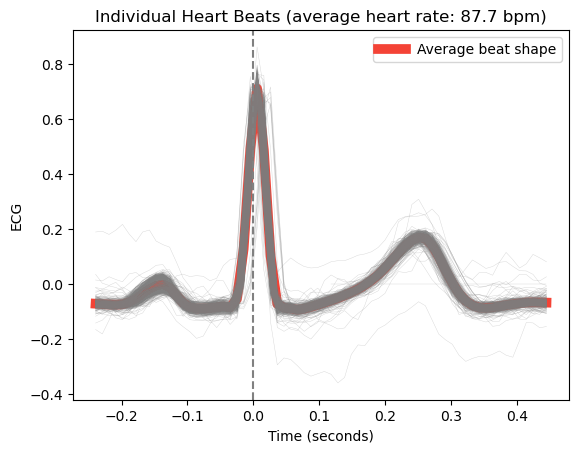

In [37]:
nst01_baseline_HR = nk.ecg_clean(nst01_baseline['CH2'], sampling_rate=100, method="neurokit")
nk.ecg_segment(nst01_baseline_HR, rpeaks=None, sampling_rate=100, show=True);

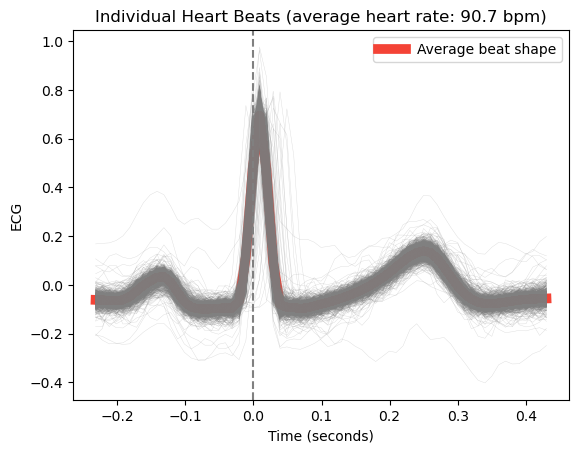

In [38]:
nst01_driving_HR = nk.ecg_clean(nst01_driving['CH2'], sampling_rate=100, method="neurokit")
nk.ecg_segment(nst01_driving_HR, rpeaks=None, sampling_rate=100, show=True);

In [40]:
# Find peaks
baseline_peaks, baseline_info = nk.ecg_peaks(nst01_baseline_HR, sampling_rate=100)
driving_peaks, driving_info = nk.ecg_peaks(nst01_driving_HR, sampling_rate=100)

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,684.191344,27.502093,5.674514,26.950077,6.396534,27.612169,NaN,NaN,18.481139,18.502216,...,30.0,1.488117,660.0,710.0,0.22779,18.451025,610.0,760.0,5.853333,93.75


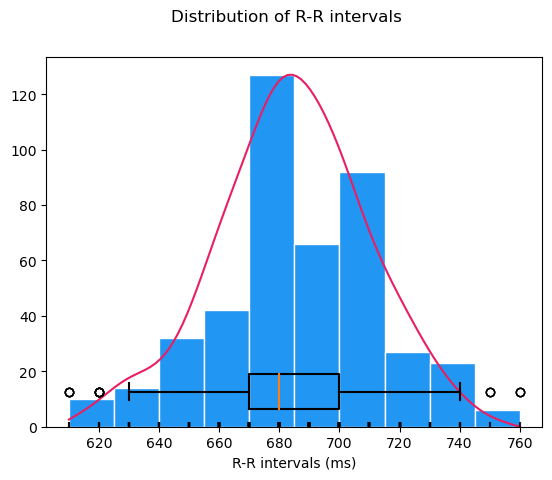

In [41]:
# Extract clean EDA and SCR features
hrv_time = nk.hrv_time(baseline_peaks, sampling_rate=100, show=True)
hrv_time

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,661.798125,31.841375,17.328005,26.781823,14.401689,28.635692,11.446394,30.210669,16.207812,16.212282,...,40.0,1.96457,640.0,690.0,0.220629,10.865968,570.0,790.0,7.617647,0.0


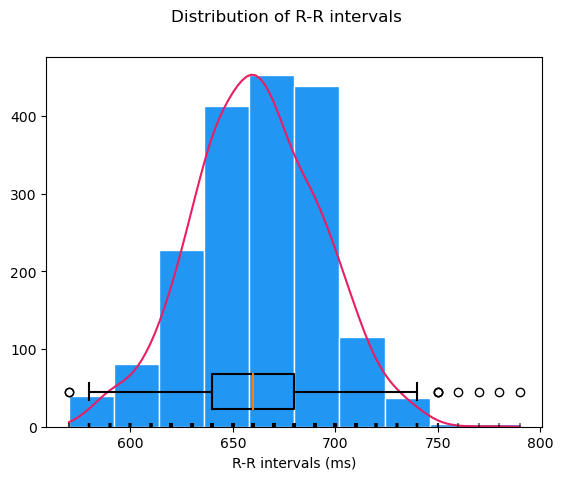

In [42]:
# Extract clean EDA and SCR features
hrv_time = nk.hrv_time(driving_peaks, sampling_rate=100, show=True)
hrv_time

These features include the RMSSD (square root of the mean of the sum of successive differences between adjacent RR intervals), MeanNN (mean of RR intervals) so on and so forth. 

,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,NaN,0.014423,0.025423,0.011742,0.000691,0.052279,2.165083,0.486293,0.224607,-4.444558


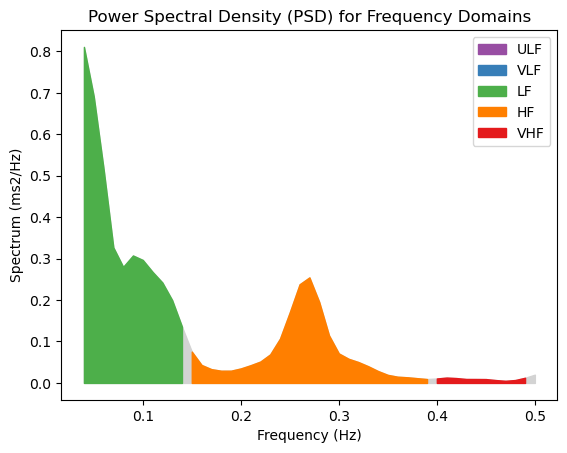

In [43]:
hrv_freq = nk.hrv_frequency(baseline_peaks, sampling_rate=100, show=True, normalize=True)
hrv_freq

,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF
0,NaN,0.007361,0.006417,0.002383,0.000178,0.016339,2.692341,0.392733,0.145871,-6.039247


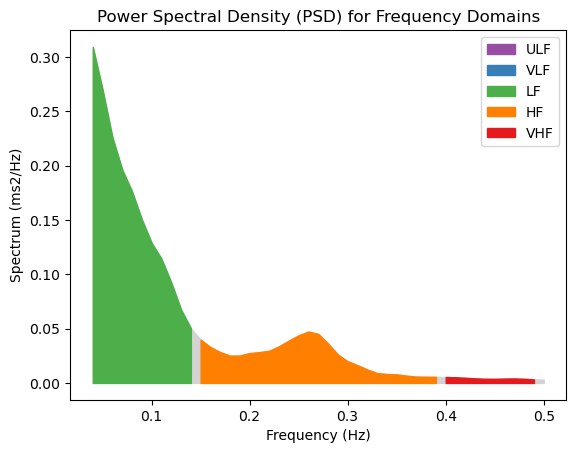

In [44]:
hrv_freq = nk.hrv_frequency(driving_peaks, sampling_rate=100, show=True, normalize=True)
hrv_freq

Extracting the frequency domain features, which involve extracting for example the spectral power density pertaining to different frequency bands.

,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,13.083043,36.668224,0.356795,1507.122345,2.802729,3.885119,411.084403,0.653759,0.61791,0.850242,...,1.884035,3.47449,1.177233,1.424337,1.40631,2.232201,1.592766,1.69403,2.99436,0.81982


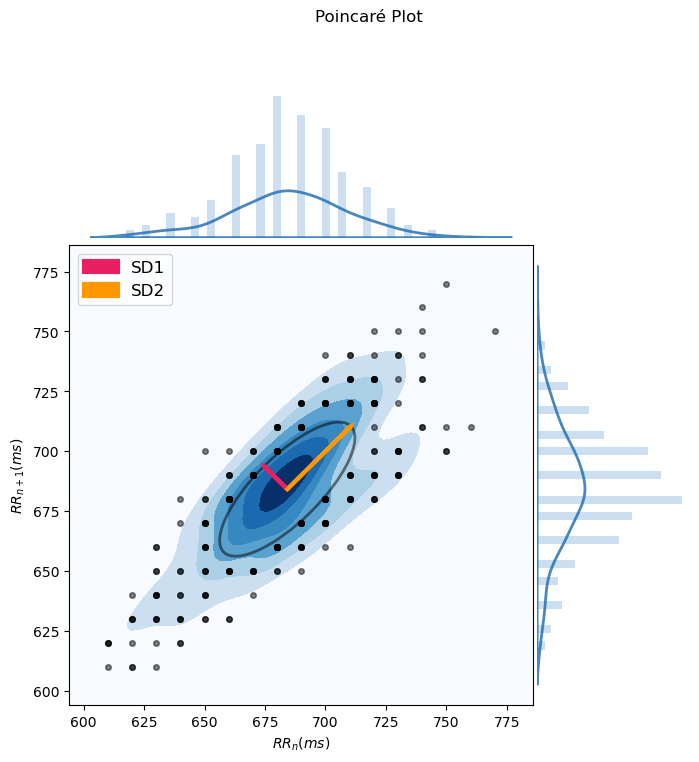

In [33]:
hrv_nonlinear = nk.hrv_nonlinear(baseline_peaks, sampling_rate=100, show=True)
hrv_nonlinear

,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,11.463815,43.545598,0.26326,1568.278862,3.798526,3.902393,661.636363,0.648649,0.611886,0.857314,...,1.639024,3.707556,0.947317,1.439447,1.326143,2.432851,1.6091,1.635605,2.859227,0.632852


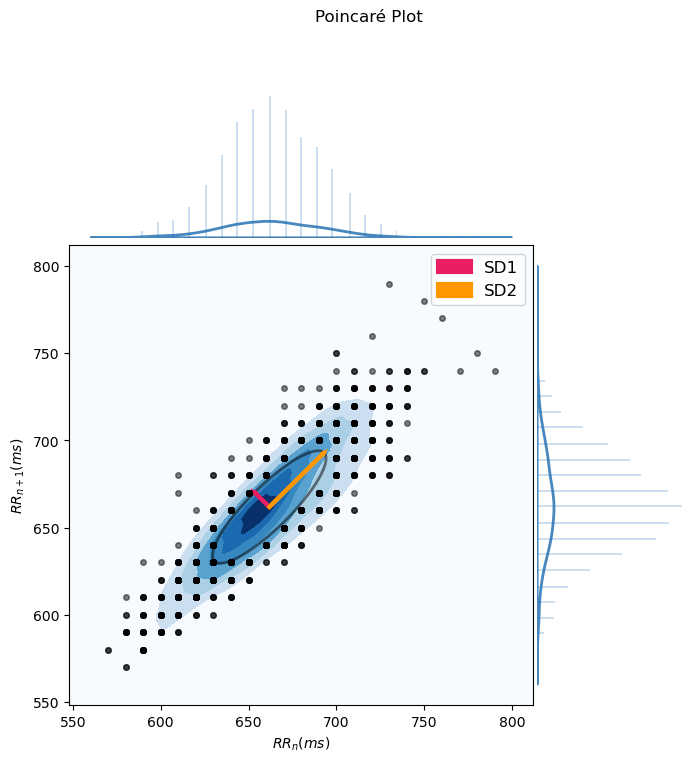

In [45]:
hrv_nonlinear = nk.hrv_nonlinear(driving_peaks, sampling_rate=100, show=True)
hrv_nonlinear